In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

### データ準備

In [2]:
"""
データセットの確認
"""
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# print(" ",X_train.shape) # (60000, 28, 28)
# print(" ",X_test.shape) # (10000, 28, 28)
# print(" ",X_train[0].dtype) # uint8
"""
平滑化
"""
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# print(" ",X_train.shape) # (60000, 784)
# print(" ",X_test.shape) # (10000, 784)
# print(" ",X_train[0].dtype) # uint8
"""
前処理
"""
# 0から255のuint8型で表される画像データを0から1のfloat型に変換
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
# print("",X_train.max()) # 1.0
# print("",X_train.min()) # 0.0

# 正解ラベルをone-hot表現に変換
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
# print("", y_train.shape) # (60000,)
# print("", y_train_one_hot.shape) # (60000, 10)
# print("", y_train_one_hot.dtype) # float64

# 訓練データ6万枚の内2割を検証データとして分割(訓練データが48000枚、検証データが12000枚)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
# print("", X_train.shape) # (48000, 784)
# print("", X_val.shape) # (12000, 784)

### ディープニューラルネットワークスクラッチ

### Layerクラス

In [3]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.X = None
        self.dB = None
        self.dW = None
    
    """
    フォワード
    """
    def forward(self, X):
         
        self.X = X
        return X@self.W + self.B
    
    """
    バックワード
    """
    def backward(self, dA):
        
        dZ = dA.dot(self.W.T)
        self.dB = np.sum(dA, axis=0)
        self.dW = self.X.T@dA
        self.optimizer.update(self)
        return dZ

In [4]:
"""
活性化関数：ハイパボリックタンジェント
"""
class Tanh:
    
    def __init__(self):
        self.z = None
        
    def forward(self, a):
        self.z = np.tanh(a)
        return self.z
    
    def backward(self, dz):
        return dz * (1 - self.z ** 2)
    

In [5]:
"""
活性化関数：ReLu
"""
class ReLU:
    
    def __init__(self):
        self.a = None
    
    def forward(self, a):
        self.a = a
        return np.clip(a, 0, None)
    
    def backward(self, dZ):
        return dZ * np.clip(np.sign(self.a), 0, None)

In [6]:
"""
Softmax
"""
class Softmax:
    
    def forward(self, X):
        self.Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return self.Z
    
    def backward(self, Y):
        return self.Z - Y

### Initializerクラス

In [7]:
"""
ガウス分布によるシンプルな初期化
"""
class SimpleInitializer:
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        # shape(n_nodes1, n_nodes2)
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        # shape(n_nodes2, )
        return self.sigma * np.random.randn(n_nodes2)

In [8]:
"""
Xavierによる初期化
"""
class XavierInitializer:
    
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(1 / n_nodes1)
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2)

In [9]:
"""
Heによる初期化
"""
class HeInitializer():
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.sigma = math.sqrt(2 / n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(n_nodes2)
        return B

### Optimizerクラス

In [10]:
"""
確率的勾配降下法
"""
class SGD:
    
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB
        return layer

In [11]:
"""
AdaGrad
"""
class AdaGrad:
    
    def __init__(self, lr):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    
    def update(self, layer):
        self.HW += layer.dW**2
        self.HB += layer.dB**2
        layer.W -= self.lr * np.sqrt(1/self.HW) * layer.dW
        layer.B -= self.lr * np.sqrt(1/self.HB) * layer.dB
        return layer

### Utilityクラス

In [12]:
"""
ミニバッチを取得するイテレータ
"""
class GetMiniBatch:
    
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [13]:
"""
定数クラス
"""
# クラス定義そのものに対してのsetter制御用メタクラス
class ConstMeta(type):
    def __setattr__(self, name, value):
        if name in self.__dict__:
            raise TypeError(f'Can\'t rebind const ({name})')
        else:
            self.__setattr__(name, value)

# 定数定義
class MyKey(metaclass=ConstMeta):
    
    # Optimizer
    SGD = "SGD"
    ADA_GRAD = "AdaGrad"
    OPTIMIZER_LIST = [SGD, ADA_GRAD]
    # Initialize
    SIMPLE_INI = "SimpleInitializer"
    XAVIER = "XavierInitializer"
    HE = "HeInitializer"
    INITIALIZE_LIST = [SIMPLE_INI, XAVIER, HE]
    # Layer
    TAN_H = "Tanh"
    ReLU = "ReLU"
    LAYER_LIST = [TAN_H, ReLU]

### Tranerクラス

In [14]:
"""
ディープニューラルネットワークスクラッチ
"""
class ScratchDeepNeuralNetrowkClassifier:
    
    def __init__(self, lr = 0.01, sigma = 0.01, 
                 n_nodes1 = 400, n_nodes2 = 200, n_output = 10,
                 n_epochs = 15, batch_size = 20, verbose = True,
                 optimizer_key = MyKey.SGD,
                 ini_key = MyKey.SIMPLE_INI,
                 act_key = MyKey.TAN_H):
        
        self.lr = lr # 学習率
        self.sigma = sigma # ガウス分布の標準偏差
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力層のノード数
        self.verbose = verbose # Trueの場合、学習過程を出力
        self.n_epochs = n_epochs # エポック数
        self.batch_size = batch_size # バッチサイズ
        self.optimizer_key = optimizer_key 
        self.ini_key = ini_key
        self.act_key = act_key
        self.train_loss_list = np.zeros((self.n_epochs))
        self.val_loss_list = np.zeros((self.n_epochs))
        
        self.n_features = None
        self.FC1, self.FC2, self.FC3 = None, None, None # n層目の全結合層
        self.activation1, self.activation2, self.activation3 = None, None, None # n層目の活性化関数
        
    """
    ニューラルネットワーク分類器を学習する。
    """
    def fit(self, X, y, X_val=None, y_val=None):
        
        self.n_features = X.shape[1] # 特徴量の数
        has_val = X_val is not None
        self._initializ() # Layerクラス、Initializerクラス、Optimizerクラスの初期化
        
        # エポック数分繰り返す
        for i in range(self.n_epochs):
            
            # ミニバッチ取得
            get_mini_batch = GetMiniBatch(X, y, self.batch_size)
            # ミニバッチの個数分ループ
            for mini_X_train, mini_y_train in get_mini_batch:
                # OneHot表現
                mini_y_one_hot = self._convert_one_hot(mini_y_train)
                # フォワード
                Z = self._forward_propagation(mini_X_train)
                # 誤差を算出
                loss = self._get_loss(mini_y_one_hot, Z)
                # バックワード
                self._back_propagation(mini_X_train, mini_y_one_hot)
            
            # 誤差を記録する
            if has_val:
                z = self._forward_propagation(X_val)
                self.val_loss_list[i] = self._get_loss(self._convert_one_hot(y_val), z)
            self.train_loss_list[i] = loss
        
        # verboseをTrueにした際は学習過程などを出力する
        if self.verbose:
            
            self.show_result(has_val)
        
    """
    Layerクラス、Initializerクラス、Optimizerクラスの初期化
    """
    def _initializ(self):
        
        # Python にはswitch文がない？
        
        if MyKey.SGD == self.optimizer_key:
            optimizer1 = SGD(self.lr)
            optimizer2 = SGD(self.lr)
            optimizer3 = SGD(self.lr)
        else:
            optimizer1 = AdaGrad(self.lr)
            optimizer2 = AdaGrad(self.lr)
            optimizer3 = AdaGrad(self.lr)
            
        if MyKey.SIMPLE_INI == self.ini_key:
            initializer = SimpleInitializer(self.sigma)
        elif MyKey.XAVIER == self.ini_key:
            initializer = XavierInitializer(self.sigma)
        else:
            initializer = HeInitializer(self.sigma)
        
        if MyKey.TAN_H == self.act_key:
            self.activation1 = Tanh()
            self.activation2 = Tanh()
        else:
            self.activation1 = ReLU()
            self.activation2 = ReLU()
        
        self.activation3 = Softmax()
        
        self.FC1 = FC(self.n_features, self.n_nodes1, initializer, optimizer1)
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer, optimizer2)
        self.FC3 = FC(self.n_nodes2, self.n_output, initializer, optimizer3)
                
    """
    フォワードプロパゲーション
    """
    def _forward_propagation(self, X):
        
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        return Z3
    
    """
    バックプロパゲーション
    """
    def _back_propagation(self, X, y_one_hot):
        
        dA3 = self.activation3.backward(y_one_hot) # 交差エントロピー誤差とソフトマックスを合わせている
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
    
    """
    OneHot表現に変換
    """
    def _convert_one_hot(self, y):
        return (y.reshape(-1, 1) == np.arange(self.n_output)).astype(np.float64)
    
    """
    lossを算出
    """
    def _get_loss(self, y_one_hot, z):
        return -(y_one_hot * np.log(z)).mean(axis=0).sum()
    
    """
    結果を表示
    """
    def show_result(self, has_val):
        # print("  ノード数：",self.n_nodes1, self.n_nodes2, self.n_output)
        print("  エポック数          ：", self.n_epochs)
        print("  学習率              ：", self.lr)
        # print("  バッチサイズ：",self.batch_size)
        print("  最適化手法          ：", self.optimizer_key)
        print("  初期化手法          ：", self.ini_key)
        print("  活性化関数          ：", self.act_key)
        # plt.xlim(0, self.n_epochs)
        # plt.ylim(0, 1.5)
        plt.plot(range(self.n_epochs), self.train_loss_list, color='r', label='train_loss')
        if has_val:
            plt.plot(range(self.n_epochs), self.val_loss_list, color='b', label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
    
    """
    推定
    """
    def predict(self, X):
        return self._forward_propagation(X).argmax(axis=1)
    

### 【問題9】学習と推定

In [17]:
# 結果比較用のクラス
import pandas as pd

class Show_result():
    def __init__(self):
        self.cols = ["   accuracy_score", "opt","ini", "act", "la", "epoc"]
        self.result_df = pd.DataFrame(index=[], columns=self.cols)

    def add_result(self, score, opt, ini, act, lr, epo):
        
        record = pd.Series([score, opt, ini, act, lr, epo], index=self.result_df.columns)
        self.result_df = self.result_df.append(record, ignore_index=True)
    
    def show_result(self):
        print(self.result_df.sort_values('   accuracy_score', ascending=False))

#### グリッドサーチで最適な組み合わせを探してみる

  エポック数          ： 20
  学習率              ： 0.01
  最適化手法          ： SGD
  初期化手法          ： SimpleInitializer
  活性化関数          ： Tanh


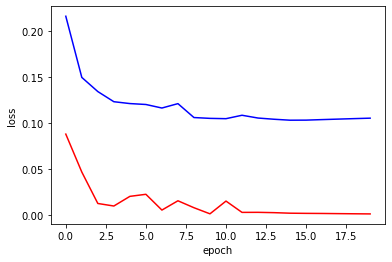

   accuracy_score :  0.97975
------------------------------------------------- 1 /48
  エポック数          ： 20
  学習率              ： 0.001
  最適化手法          ： SGD
  初期化手法          ： SimpleInitializer
  活性化関数          ： Tanh


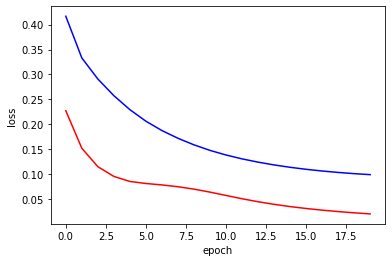

   accuracy_score :  0.9709166666666667
------------------------------------------------- 2 /48
  エポック数          ： 20
  学習率              ： 0.0001
  最適化手法          ： SGD
  初期化手法          ： SimpleInitializer
  活性化関数          ： Tanh


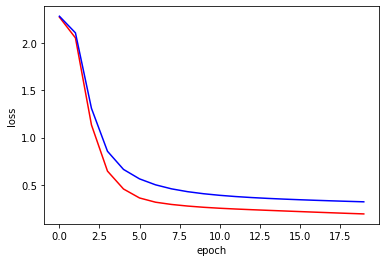

   accuracy_score :  0.9089166666666667
------------------------------------------------- 3 /48
  エポック数          ： 20
  学習率              ： 0.01
  最適化手法          ： SGD
  初期化手法          ： SimpleInitializer
  活性化関数          ： ReLU


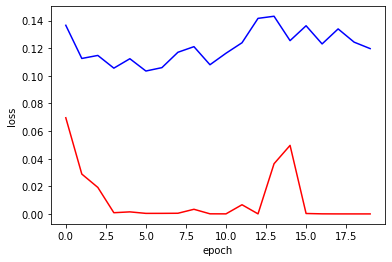

   accuracy_score :  0.98075
------------------------------------------------- 4 /48
  エポック数          ： 20
  学習率              ： 0.001
  最適化手法          ： SGD
  初期化手法          ： SimpleInitializer
  活性化関数          ： ReLU


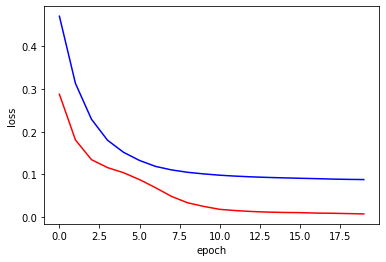

   accuracy_score :  0.97575
------------------------------------------------- 5 /48
  エポック数          ： 20
  学習率              ： 0.0001
  最適化手法          ： SGD
  初期化手法          ： SimpleInitializer
  活性化関数          ： ReLU


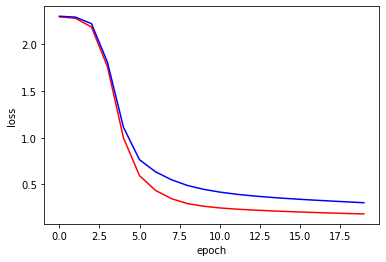

   accuracy_score :  0.91125
------------------------------------------------- 6 /48
  エポック数          ： 20
  学習率              ： 0.01
  最適化手法          ： SGD
  初期化手法          ： XavierInitializer
  活性化関数          ： Tanh


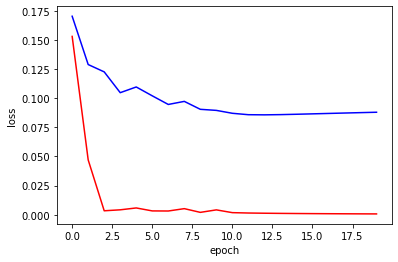

   accuracy_score :  0.9805833333333334
------------------------------------------------- 7 /48
  エポック数          ： 20
  学習率              ： 0.001
  最適化手法          ： SGD
  初期化手法          ： XavierInitializer
  活性化関数          ： Tanh


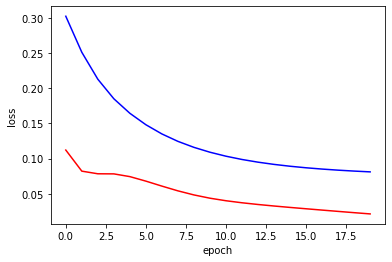

   accuracy_score :  0.9755833333333334
------------------------------------------------- 8 /48
  エポック数          ： 20
  学習率              ： 0.0001
  最適化手法          ： SGD
  初期化手法          ： XavierInitializer
  活性化関数          ： Tanh


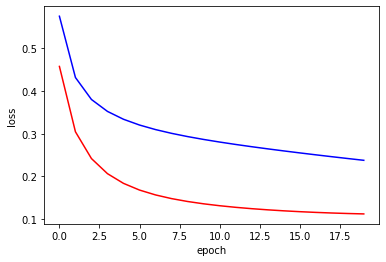

   accuracy_score :  0.9311666666666667
------------------------------------------------- 9 /48
  エポック数          ： 20
  学習率              ： 0.01
  最適化手法          ： SGD
  初期化手法          ： XavierInitializer
  活性化関数          ： ReLU


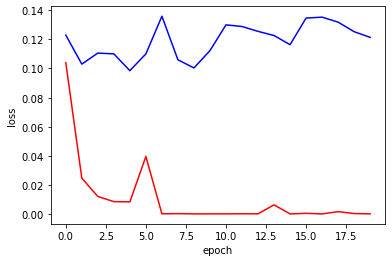

   accuracy_score :  0.9811666666666666
------------------------------------------------- 10 /48
  エポック数          ： 20
  学習率              ： 0.001
  最適化手法          ： SGD
  初期化手法          ： XavierInitializer
  活性化関数          ： ReLU


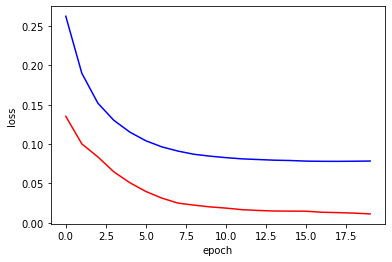

   accuracy_score :  0.9788333333333333
------------------------------------------------- 11 /48
  エポック数          ： 20
  学習率              ： 0.0001
  最適化手法          ： SGD
  初期化手法          ： XavierInitializer
  活性化関数          ： ReLU


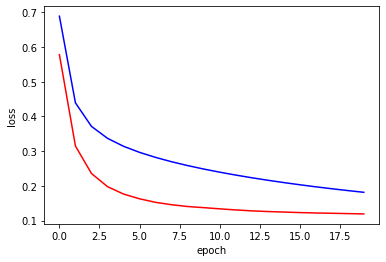

   accuracy_score :  0.9473333333333334
------------------------------------------------- 12 /48
  エポック数          ： 20
  学習率              ： 0.01
  最適化手法          ： SGD
  初期化手法          ： HeInitializer
  活性化関数          ： Tanh


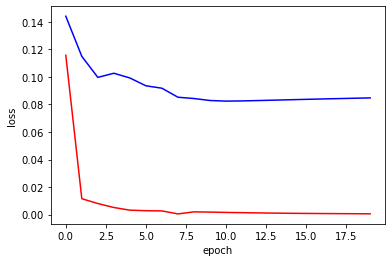

   accuracy_score :  0.98
------------------------------------------------- 13 /48
  エポック数          ： 20
  学習率              ： 0.001
  最適化手法          ： SGD
  初期化手法          ： HeInitializer
  活性化関数          ： Tanh


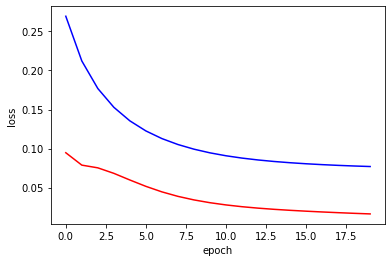

   accuracy_score :  0.97675
------------------------------------------------- 14 /48
  エポック数          ： 20
  学習率              ： 0.0001
  最適化手法          ： SGD
  初期化手法          ： HeInitializer
  活性化関数          ： Tanh


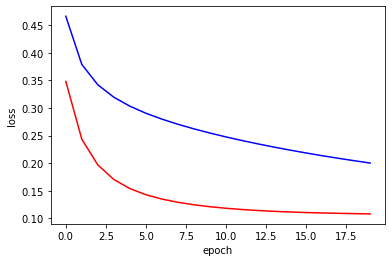

   accuracy_score :  0.9429166666666666
------------------------------------------------- 15 /48
  エポック数          ： 20
  学習率              ： 0.01
  最適化手法          ： SGD
  初期化手法          ： HeInitializer
  活性化関数          ： ReLU


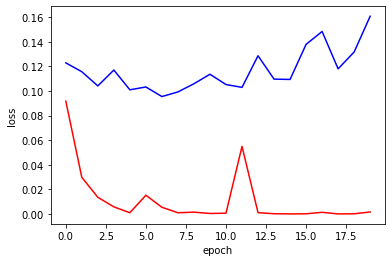

   accuracy_score :  0.9741666666666666
------------------------------------------------- 16 /48
  エポック数          ： 20
  学習率              ： 0.001
  最適化手法          ： SGD
  初期化手法          ： HeInitializer
  活性化関数          ： ReLU


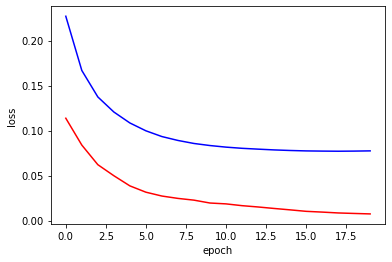

   accuracy_score :  0.97825
------------------------------------------------- 17 /48
  エポック数          ： 20
  学習率              ： 0.0001
  最適化手法          ： SGD
  初期化手法          ： HeInitializer
  活性化関数          ： ReLU


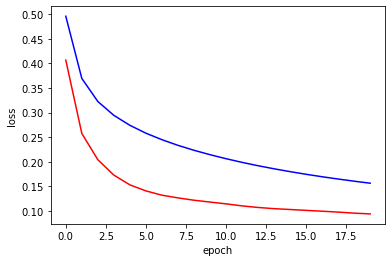

   accuracy_score :  0.95525
------------------------------------------------- 18 /48
  エポック数          ： 20
  学習率              ： 0.01
  最適化手法          ： AdaGrad
  初期化手法          ： SimpleInitializer
  活性化関数          ： Tanh


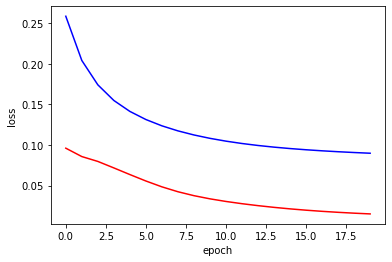

   accuracy_score :  0.9731666666666666
------------------------------------------------- 19 /48
  エポック数          ： 20
  学習率              ： 0.001
  最適化手法          ： AdaGrad
  初期化手法          ： SimpleInitializer
  活性化関数          ： Tanh


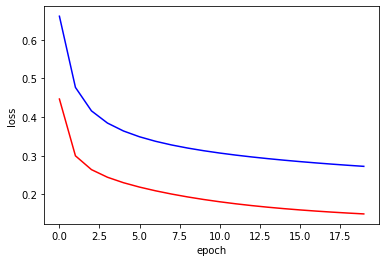

   accuracy_score :  0.9196666666666666
------------------------------------------------- 20 /48
  エポック数          ： 20
  学習率              ： 0.0001
  最適化手法          ： AdaGrad
  初期化手法          ： SimpleInitializer
  活性化関数          ： Tanh


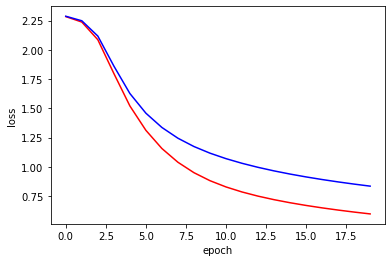

   accuracy_score :  0.76975
------------------------------------------------- 21 /48
  エポック数          ： 20
  学習率              ： 0.01
  最適化手法          ： AdaGrad
  初期化手法          ： SimpleInitializer
  活性化関数          ： ReLU


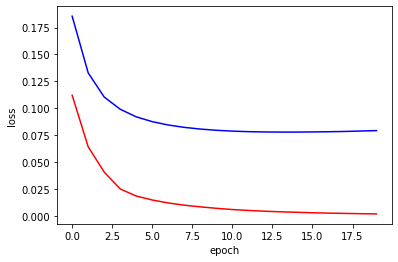

   accuracy_score :  0.9789166666666667
------------------------------------------------- 22 /48
  エポック数          ： 20
  学習率              ： 0.001
  最適化手法          ： AdaGrad
  初期化手法          ： SimpleInitializer
  活性化関数          ： ReLU


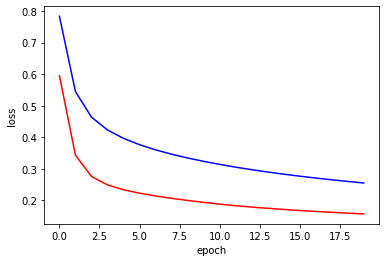

   accuracy_score :  0.9255
------------------------------------------------- 23 /48
  エポック数          ： 20
  学習率              ： 0.0001
  最適化手法          ： AdaGrad
  初期化手法          ： SimpleInitializer
  活性化関数          ： ReLU


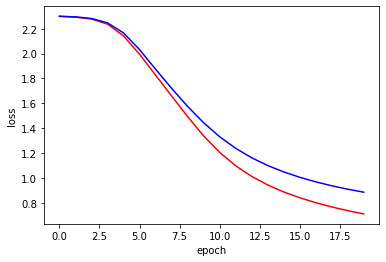

   accuracy_score :  0.7421666666666666
------------------------------------------------- 24 /48
  エポック数          ： 20
  学習率              ： 0.01
  最適化手法          ： AdaGrad
  初期化手法          ： XavierInitializer
  活性化関数          ： Tanh


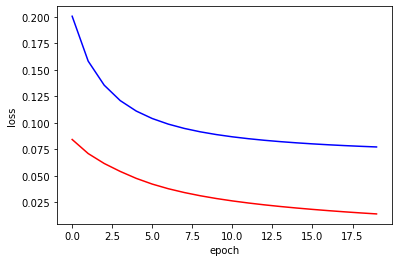

   accuracy_score :  0.9765
------------------------------------------------- 25 /48
  エポック数          ： 20
  学習率              ： 0.001
  最適化手法          ： AdaGrad
  初期化手法          ： XavierInitializer
  活性化関数          ： Tanh


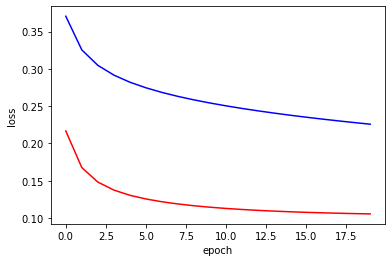

   accuracy_score :  0.93375
------------------------------------------------- 26 /48
  エポック数          ： 20
  学習率              ： 0.0001
  最適化手法          ： AdaGrad
  初期化手法          ： XavierInitializer
  活性化関数          ： Tanh


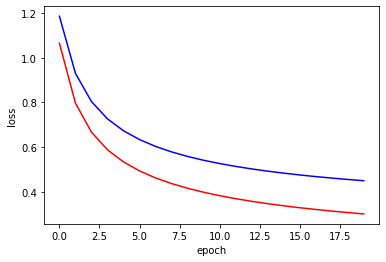

   accuracy_score :  0.8865833333333333
------------------------------------------------- 27 /48
  エポック数          ： 20
  学習率              ： 0.01
  最適化手法          ： AdaGrad
  初期化手法          ： XavierInitializer
  活性化関数          ： ReLU


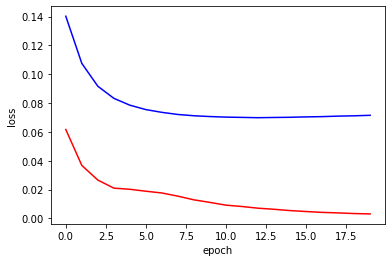

   accuracy_score :  0.9810833333333333
------------------------------------------------- 28 /48
  エポック数          ： 20
  学習率              ： 0.001
  最適化手法          ： AdaGrad
  初期化手法          ： XavierInitializer
  活性化関数          ： ReLU


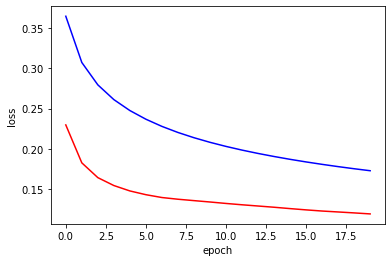

   accuracy_score :  0.9494166666666667
------------------------------------------------- 29 /48
  エポック数          ： 20
  学習率              ： 0.0001
  最適化手法          ： AdaGrad
  初期化手法          ： XavierInitializer
  活性化関数          ： ReLU


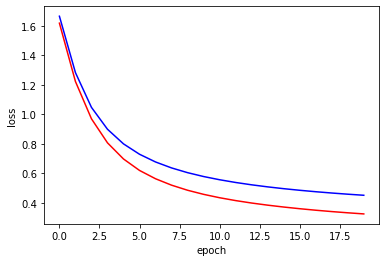

   accuracy_score :  0.8870833333333333
------------------------------------------------- 30 /48
  エポック数          ： 20
  学習率              ： 0.01
  最適化手法          ： AdaGrad
  初期化手法          ： HeInitializer
  活性化関数          ： Tanh


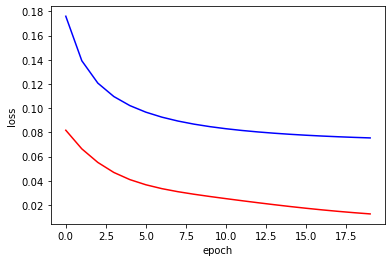

   accuracy_score :  0.9768333333333333
------------------------------------------------- 31 /48
  エポック数          ： 20
  学習率              ： 0.001
  最適化手法          ： AdaGrad
  初期化手法          ： HeInitializer
  活性化関数          ： Tanh


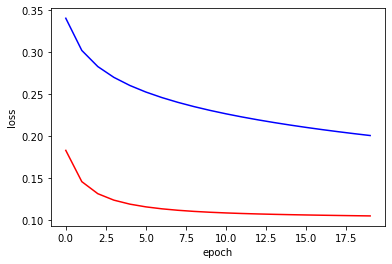

   accuracy_score :  0.9415
------------------------------------------------- 32 /48
  エポック数          ： 20
  学習率              ： 0.0001
  最適化手法          ： AdaGrad
  初期化手法          ： HeInitializer
  活性化関数          ： Tanh


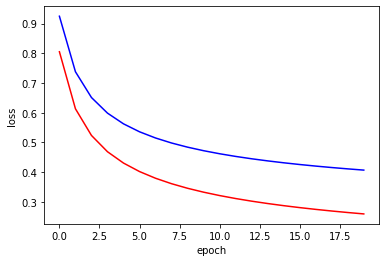

   accuracy_score :  0.89125
------------------------------------------------- 33 /48
  エポック数          ： 20
  学習率              ： 0.01
  最適化手法          ： AdaGrad
  初期化手法          ： HeInitializer
  活性化関数          ： ReLU


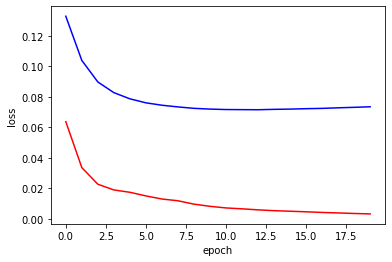

   accuracy_score :  0.97925
------------------------------------------------- 34 /48
  エポック数          ： 20
  学習率              ： 0.001
  最適化手法          ： AdaGrad
  初期化手法          ： HeInitializer
  活性化関数          ： ReLU


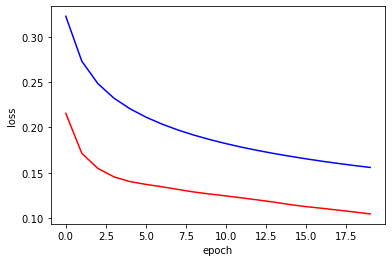

   accuracy_score :  0.95325
------------------------------------------------- 35 /48
  エポック数          ： 20
  学習率              ： 0.0001
  最適化手法          ： AdaGrad
  初期化手法          ： HeInitializer
  活性化関数          ： ReLU


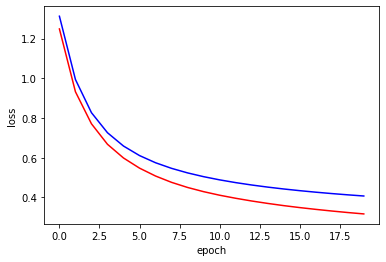

   accuracy_score :  0.8923333333333333
------------------------------------------------- 36 /48


In [18]:
from sklearn.metrics import accuracy_score

n_epochs_list = [20]
lr_list = [0.01, 0.001, 0.0001]
show_result = Show_result()
i = 0
for opt in MyKey.OPTIMIZER_LIST:
    for ini in MyKey.INITIALIZE_LIST:
        for act in MyKey.LAYER_LIST:
            for lr in lr_list:
                for epo in n_epochs_list:
                    scr_nn = ScratchDeepNeuralNetrowkClassifier(n_epochs = epo,
                                                                lr = lr,
                                                                optimizer_key = opt,
                                                                ini_key = ini,
                                                                act_key = act,
                                                                verbose = True)
    
                    scr_nn.fit(X_train, y_train, X_val, y_val) # 学習
                    y_pred = scr_nn.predict(X_val) # 推定
                    score = accuracy_score(y_val, y_pred)
                    show_result.add_result(score, opt, ini, act, lr, epo)
                    i +=1
                    print("   accuracy_score : ", score)
                    print("-------------------------------------------------",i,"/48")

In [19]:
show_result.show_result()

       accuracy_score      opt                ini   act      la epoc
9            0.981167      SGD  XavierInitializer  ReLU  0.0100   20
27           0.981083  AdaGrad  XavierInitializer  ReLU  0.0100   20
3            0.980750      SGD  SimpleInitializer  ReLU  0.0100   20
6            0.980583      SGD  XavierInitializer  Tanh  0.0100   20
12           0.980000      SGD      HeInitializer  Tanh  0.0100   20
0            0.979750      SGD  SimpleInitializer  Tanh  0.0100   20
33           0.979250  AdaGrad      HeInitializer  ReLU  0.0100   20
21           0.978917  AdaGrad  SimpleInitializer  ReLU  0.0100   20
10           0.978833      SGD  XavierInitializer  ReLU  0.0010   20
16           0.978250      SGD      HeInitializer  ReLU  0.0010   20
30           0.976833  AdaGrad      HeInitializer  Tanh  0.0100   20
13           0.976750      SGD      HeInitializer  Tanh  0.0010   20
24           0.976500  AdaGrad  XavierInitializer  Tanh  0.0100   20
4            0.975750      SGD  Si